In [3]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


print("\n==============================")
print(" TASK 2: SENTIMENT ANALYSIS WITH NLP")
print("==============================")


print("\n Loading the dataset into a dataframe...")



print("\n I am Loading the dataset into a dataframe...")

AirlineData = pd.read_csv('Tweets.csv')
print(AirlineData.head().to_string())
print("\n")
print(AirlineData.info())
print("\n")
print(AirlineData.shape)
print("\n")
print("Data Shape:", AirlineData.shape)
print("\nData Types:\n", AirlineData.dtypes)
print("\nMissing Values:\n", AirlineData.isnull().sum())
print("\nSummary Statistics Of Data:\n", AirlineData.describe(include='all'))

print("\n I am Exploring the datasets structure and basic information...")
print("\n Information about columns and datatypes and etc: \n")

DuplicateRowsum = AirlineData.duplicated().sum()
print("Number of duplicated rows: ",DuplicateRowsum )
print("The Duplicated Rows are: \n", AirlineData[AirlineData.duplicated()])
print("\n")
database_withDuplicatedRowsGone = AirlineData.drop_duplicates()
print("The Database Without the Duplicaed Rows Here \n ", database_withDuplicatedRowsGone.head().to_string())
print("\n")

Partial_Duplicates_Rows_Count = AirlineData.duplicated(keep=False).sum()
print("The No of Partial Duplicates Rows are: ", Partial_Duplicates_Rows_Count)
print("\n")
AirlineData_no_partial_duplicates = AirlineData.drop_duplicates(keep='first')
print(AirlineData_no_partial_duplicates.head().to_string())



print("Missing Values in each Column: \n", AirlineData.isnull().sum())
print("\n")
print("Percentage of Missing Values in each Column: \n", (AirlineData.isnull().mean()*100))

Missing_Values_Coloums_Dataframe = pd.DataFrame({
    'Missing_Values_Coloums': AirlineData.isnull().any(),
    'Missing_Values_Count': AirlineData.isnull().sum(),
    'Missing_ValuesIn_Percentage': (AirlineData.isnull().sum() / len(AirlineData)) * 100
})

print(Missing_Values_Coloums_Dataframe.to_string())


def Imputation_Of_Values(database):
    for column in database.columns:
        if np.issubdtype(database[column].dtype, np.number):
            median_value = database[column].median()
            database[column] = database[column].fillna(median_value)
            print(f"Filled NaN in numeric column '{column}' with Median = {median_value}")
        
        elif database[column].dtype == 'object':
            mode_value = database[column].mode()[0]
            database[column] = database[column].fillna(mode_value)
            print(f"Filled NaN in categorical column '{column}' with Mode = {mode_value}")
        
        elif np.issubdtype(database[column].dtype, np.datetime64):
            database[column] = database[column].interpolate(method='time')
            print(f"Interpolated missing datetime values in '{column}'")
    
    return database



[nltk_data] Downloading package stopwords to C:\Users\Vijay
[nltk_data]     Pranav\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\Vijay
[nltk_data]     Pranav\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\Vijay
[nltk_data]     Pranav\AppData\Roaming\nltk_data...



 TASK 2: SENTIMENT ANALYSIS WITH NLP

 Loading the dataset into a dataframe...

 I am Loading the dataset into a dataframe...
             tweet_id airline_sentiment  airline_sentiment_confidence negativereason  negativereason_confidence         airline airline_sentiment_gold        name negativereason_gold  retweet_count                                                                                                                            text tweet_coord              tweet_created tweet_location               user_timezone
0  570306133677760513           neutral                        1.0000            NaN                        NaN  Virgin America                    NaN     cairdin                 NaN              0                                                                                             @VirginAmerica What @dhepburn said.         NaN  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)
1  570301130888122368          positive                  

In [4]:
Database_After_Imputation = Imputation_Of_Values(SutudentData)
print("The Database After Imputation of Missing Values is : \n", Database_After_Imputation.head())


print("\n\n Statistical Explanation Defined Here : \n\n")
print(Database_After_Imputation.describe())

Filled NaN in numeric column 'tweet_id' with Median = 5.694778579231109e+17
Filled NaN in categorical column 'airline_sentiment' with Mode = negative
Filled NaN in numeric column 'airline_sentiment_confidence' with Median = 1.0
Filled NaN in categorical column 'negativereason' with Mode = Customer Service Issue
Filled NaN in numeric column 'negativereason_confidence' with Median = 0.6706
Filled NaN in categorical column 'airline' with Mode = United
Filled NaN in categorical column 'airline_sentiment_gold' with Mode = negative
Filled NaN in categorical column 'name' with Mode = JetBlueNews
Filled NaN in categorical column 'negativereason_gold' with Mode = Customer Service Issue
Filled NaN in numeric column 'retweet_count' with Median = 0.0
Filled NaN in categorical column 'text' with Mode = @united thanks
Filled NaN in categorical column 'tweet_coord' with Mode = [0.0, 0.0]
Filled NaN in categorical column 'tweet_created' with Mode = 2015-02-24 09:54:34 -0800
Filled NaN in categorical c

In [5]:
print("\n Cleaning and preprocessing the text data...")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()                                           
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)           
    text = re.sub(r"@\w+|#", '', text)                            
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  
    text = re.sub(r'\d+', '', text)                              
    tokens = text.split()                                        
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  
    return ' '.join(tokens)

print("\nCleaning text data... This might take a few seconds.\n")
Database_After_Imputation['clean_text'] = Database_After_Imputation['text'].apply(clean_text)
print("Sample cleaned text:\n")
print(Database_After_Imputation[['text', 'clean_text']].head(3).to_string())





 Cleaning and preprocessing the text data...

Cleaning text data... This might take a few seconds.

Sample cleaned text:

                                                                       text                                    clean_text
0                                       @VirginAmerica What @dhepburn said.                                          said
1  @VirginAmerica plus you've added commercials to the experience... tacky.  plus youve added commercial experience tacky
2   @VirginAmerica I didn't today... Must mean I need to take another trip!  didnt today must mean need take another trip


In [6]:

print("\n: Converting text into numerical format using TF-IDF Vectorization...")

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(Database_After_Imputation['clean_text'])
y = Database_After_Imputation['airline_sentiment']

print("Shape of TF-IDF matrix:", X.shape)







: Converting text into numerical format using TF-IDF Vectorization...
Shape of TF-IDF matrix: (14640, 5000)


In [ ]:

print("\n Splitting the dataset into training and testing sets (80-20 split)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


print("\n Training a Logistic Regression model for sentiment classification...")
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
print("Model trained successfully!")



 Splitting the dataset into training and testing sets (80-20 split)...
Training samples: 11712, Testing samples: 2928

STEP 5: Training a Logistic Regression model for sentiment classification...
Model trained successfully!



 Evaluating the model on the test set...

 Model Accuracy: 79.85%
Precision: 0.790
Recall: 0.798
F1-Score: 0.786

Classification Report:

              precision    recall  f1-score   support

    negative       0.82      0.94      0.88      1889
     neutral       0.67      0.49      0.57       580
    positive       0.82      0.60      0.69       459

    accuracy                           0.80      2928
   macro avg       0.77      0.68      0.71      2928
weighted avg       0.79      0.80      0.79      2928



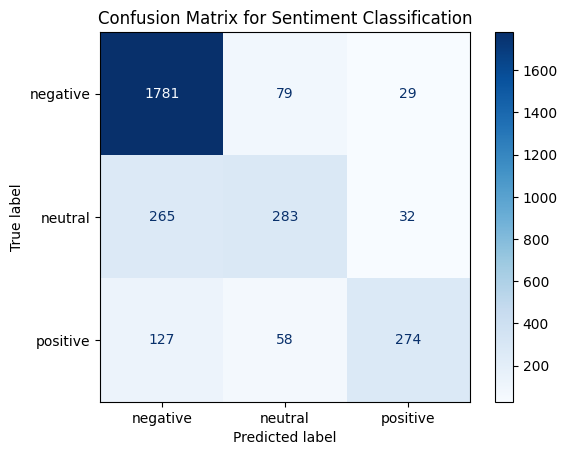

In [8]:

print("\n Evaluating the model on the test set...")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n Model Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Sentiment Classification")
plt.show()



 Visualizing class distribution and key insights...


C:\Users\Vijay Pranav\AppData\Local\Temp\ipykernel_38120\676166924.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=Database_After_Imputation, palette='Set2')


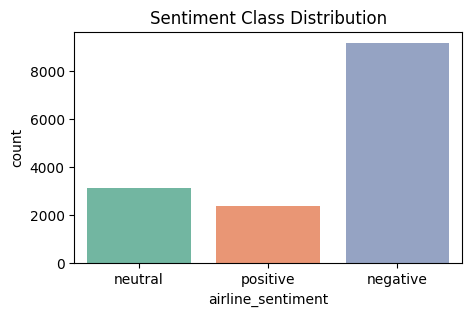


Displaying examples of correctly and incorrectly classified reviews...

 Correctly Classified Samples:
                                                                                                                        Text    Actual Predicted
4794                                                 @SouthwestAir you're my early frontrunner for best airline! #oscars2016  positive  positive
10480       @USAirways how is it that my flt to EWR was Cancelled Flightled yet flts to NYC from USAirways are still flying?  negative  negative
8067   @JetBlue what is going on with your BDL to DCA flights yesterday and today?! Why is every single one getting delayed?  negative  negative

 Incorrectly Classified Samples:
                                                                                                                                               Text    Actual Predicted
8292                                                                         @JetBlue I can probably find some of 

In [9]:

print("\n Visualizing class distribution and key insights...")

plt.figure(figsize=(5,3))
sns.countplot(x='airline_sentiment', data=Database_After_Imputation, palette='Set2')
plt.title("Sentiment Class Distribution")
plt.show()

print("\nDisplaying examples of correctly and incorrectly classified reviews...")

comparison_df = pd.DataFrame({'Text': Database_After_Imputation['text'].iloc[y_test.index],
                              'Actual': y_test,
                              'Predicted': y_pred})

print("\n Correctly Classified Samples:")
print(comparison_df[comparison_df['Actual'] == comparison_df['Predicted']].head(3).to_string())

print("\n Incorrectly Classified Samples:")
print(comparison_df[comparison_df['Actual'] != comparison_df['Predicted']].head(3).to_string())


In [ ]:

print("\n Generating feature importance insights (most influential words)...")

feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = model.coef_


for idx, sentiment in enumerate(model.classes_):
    print(f"\nTop 10 influential words for '{sentiment}' sentiment:")
    top10 = np.argsort(coefficients[idx])[-10:]
    print(feature_names[top10])

print("\n Task 2 completed successfully!")


 Generating feature importance insights (most influential words)...

Top 10 influential words for 'negative' sentiment:
['fail' 'delay' 'luggage' 'fix' 'bag' 'cancelled' 'hr' 'delayed' 'worst'
 'hour']

Top 10 influential words for 'neutral' sentiment:
['march' 'fleek' 'number' 'photo' 'carry' 'atlanta' 'dm' 'avgeek' 'dal'
 'hi']

Top 10 influential words for 'positive' sentiment:
['thx' 'appreciate' 'excellent' 'love' 'best' 'amazing' 'awesome' 'great'
 'thank' 'thanks']

 Task 2 completed successfully!
